In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import GPy
import pymc3 as pm
from theano import tensor as tt
import matplotlib.pyplot as plt

from data.get_results import get_results
from likelihood import get_kernel
from acquisitions import local_acq, phase_ucb_acq, generate, likelihood

 E:\Program_Files\Anaconda\envs\testpymc3\lib\site-packages\h5py\__init__.py:36: FutureWarning:Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


In [2]:
results = get_results('data/results.json').iloc[3:]
function_names = results['function_name'].unique()
kernel_dict = {f: get_kernel(results, GPy.kern.RBF(1), f) for f in function_names}
functions_dict = results[['function_name', 'function']].drop_duplicates(subset = ['function_name']).set_index('function_name').to_dict()['function']
normalized_functions_dict = {f: np.array(functions_dict[f]) / np.std(functions_dict[f]) for f in function_names}

## Simulate actions with negative quadratic reward

In [3]:
neg_quad = normalized_functions_dict['neg_quad']
neg_quad_kern = kernel_dict['neg_quad']
fmax = np.argmax(neg_quad)

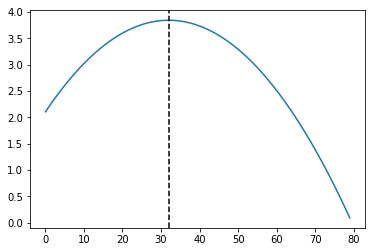

In [4]:
plt.plot(neg_quad);
plt.axvline(x=fmax, ls='--', c='black');

## Strategies

In [5]:
learning_rate_params = [0, 0, 350, 350]
stay_penalty_params = [0, -10, 0, -10]
temp_params = [.1, .15, .2]
trials = np.arange(20)
titles = ['Local Search', 'Local Search (Stay Penalty)', 'Gradient Ascent', 'Gradient Ascent (Stay Penalty)']

In [6]:
data = [[generate(local_acq, {'learning_rate': [learning_rate_params[i]], 'stay_penalty': [stay_penalty_params[i]], 'temperature': [temp_params[j]]},
        neg_quad_kern, neg_quad, 20, 10, 1, [1.])[0] for i in range(len(learning_rate_params))] for j in range(len(temp_params))]

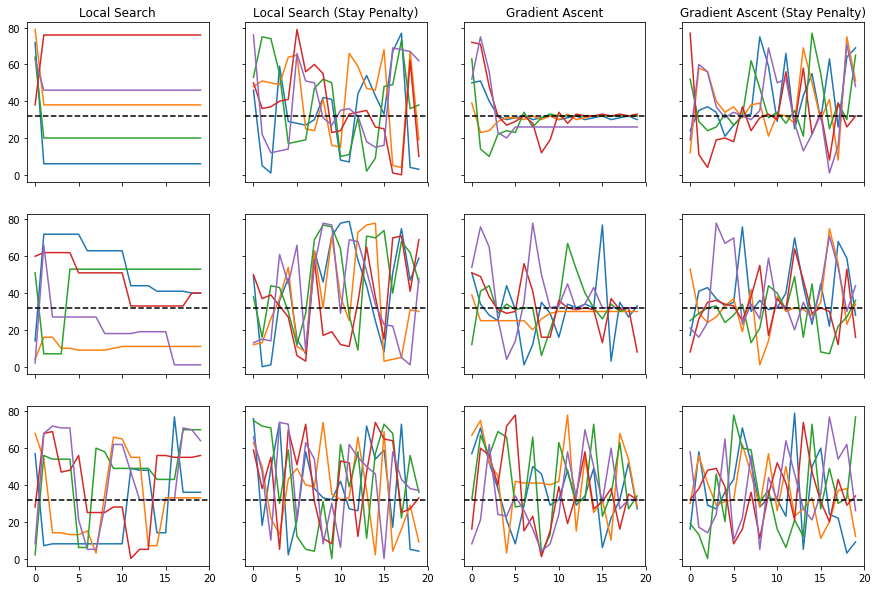

In [7]:
fig, axes = plt.subplots(len(temp_params), len(learning_rate_params), sharex=True, sharey=True, figsize=(15,10))
for j in range(len(temp_params)):
    for i in range(len(learning_rate_params)):
        actions = data[j][i][:,:,5].argmax(axis=2)
        axes[j][i].plot(actions[:5].T);
        axes[j][i].axhline(y=fmax, ls='--', c='black');
        if j == 0:
            axes[j][i].set_title(titles[i])

In [8]:
local = generate(local_acq, {'learning_rate': [0], 'stay_penalty': [0], 'temperature': [.15]},
        neg_quad_kern, neg_quad, 20, 10, 1, [1.])[0]

## Learning Rate Prior

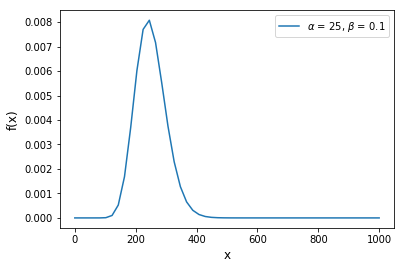

In [9]:
x = np.linspace(0, 1000)
alphas = [25]
betas = [.1]
for a, b in zip(alphas, betas):
    pdf = st.gamma.pdf(x, a, scale=1.0/b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

## Local Search

In [10]:
with pm.Model() as model:
    learning_rate = pm.Gamma('learning_rate', 25., .1, shape=1)
    stay_penalty = pm.Normal('stay_penalty', 0, 20, shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][0], local_acq, {'learning_rate': learning_rate, 
                               'temperature': temperature, 'stay_penalty': stay_penalty}, 1, [1.]))
    local_trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, stay_penalty, learning_rate]
Sampling 4 chains: 100%|██████████| 2800/2800 [00:15<00:00, 184.01draws/s]


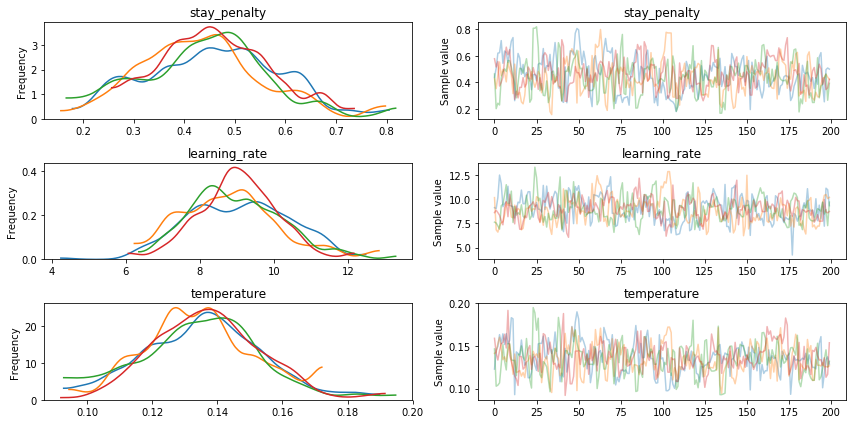

In [11]:
pm.traceplot(local_trace);

## Local Search (Stay Penalty)

In [12]:
with pm.Model() as model:
    learning_rate = pm.Gamma('learning_rate', 25., .1, shape=1)
    stay_penalty = pm.Normal('stay_penalty', 0, 20, shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][1], local_acq, {'learning_rate': learning_rate, 
                               'temperature': temperature, 'stay_penalty': stay_penalty}, 1, [1.]))
    local_penalty_trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, stay_penalty, learning_rate]
Sampling 4 chains: 100%|██████████| 2800/2800 [00:46<00:00, 60.60draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


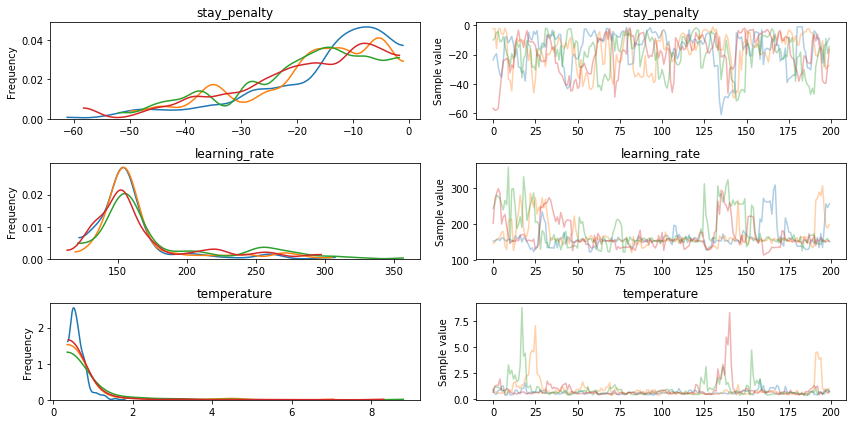

In [13]:
pm.traceplot(local_penalty_trace);

## Gradient Ascent

In [14]:
with pm.Model() as model:
    learning_rate = pm.Gamma('learning_rate', 25., .1, shape=1)
    stay_penalty = pm.Normal('stay_penalty', 0, 20, shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][2], local_acq, {'learning_rate': learning_rate, 
                               'temperature': temperature, 'stay_penalty': stay_penalty}, 1, [1.]))
    gradient_trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, stay_penalty, learning_rate]
Sampling 4 chains: 100%|██████████| 2800/2800 [00:14<00:00, 193.91draws/s]
The acceptance probability does not match the target. It is 0.8886678642433755, but should be close to 0.8. Try to increase the number of tuning steps.


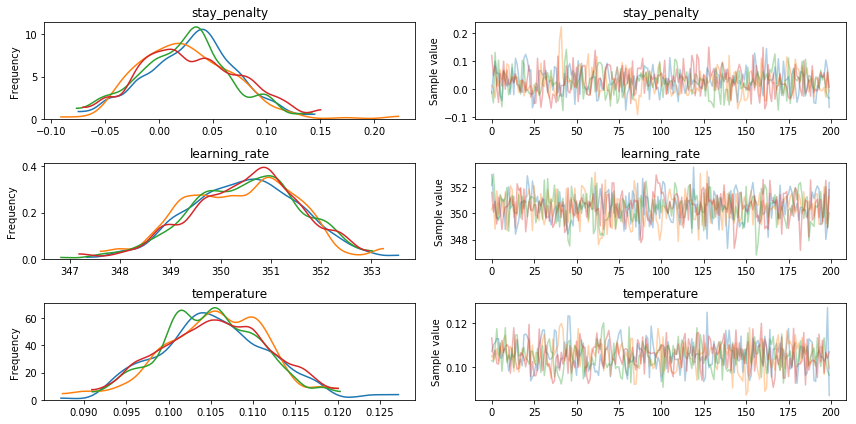

In [15]:
pm.traceplot(gradient_trace);

## Gradient Ascent (Stay Penalty)

In [21]:
with pm.Model() as model:
    learning_rate = pm.Gamma('learning_rate', 25., .1, shape=1)
    stay_penalty = pm.Normal('stay_penalty', 0, 20, shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][3], local_acq, {'learning_rate': learning_rate, 
                               'temperature': temperature, 'stay_penalty': stay_penalty}, 1, [1.]))
    gradient_penalty_trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, stay_penalty, learning_rate]
Sampling 4 chains: 100%|██████████| 2800/2800 [00:36<00:00, 76.98draws/s] 
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


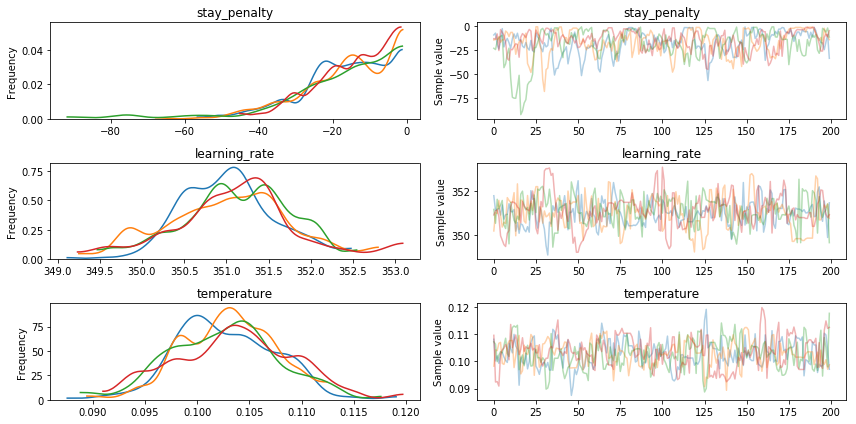

In [22]:
pm.traceplot(gradient_penalty_trace);